In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.signal import savgol_filter
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.signal import savgol_filter
import logging

logger = logging.getLogger(__name__)

In [ ]:
joint_positions = pd.read_csv("joint_positions.csv")

In [65]:
# Initialize dictionary to store per-patient DataFrames
patient_data = {}

# Loop over each unique patient/therapist
for patient_id in joint_positions['Patient'].unique():
    print(f"Processing patient/therapist: {patient_id}")
    
    # Subset data for the current patient
    df_patient = joint_positions[joint_positions['Patient'] == patient_id]

    df_pivot = df_patient.pivot_table(index='Frame', columns='Joint', values='Y')

    # Reset index so Frame becomes a column, not the index
    df_pivot.reset_index(inplace=True)

    # Rename columns: e.g., 'LHip' → 'Y_LHip'
    df_pivot.columns = ['Frame'] + [f"Y_{joint}" for joint in df_pivot.columns if joint != 'Frame']

    # Save the DataFrame to the patient_data dictionary
    patient_data[patient_id] = df_pivot
    print(f"Patient {patient_id} data shape: {df_pivot.shape}")

print("="*50)

# Combine all patient DataFrames into one
df_list = []

for patient_id, df_pivot in patient_data.items():
    df_temp = df_pivot.copy()
    df_temp['Patient'] = patient_id  # Add patient ID column
    df_list.append(df_temp)

# Concatenate all patient data vertically
df_all = pd.concat(df_list, axis=0)

print(f"Combined data shape (before dropping NAs): {df_all.shape}")

# Check missing values per column
na_counts = df_all.isna().sum()
na_percent = na_counts / len(df_all)

# Display columns with missing values
na_counts_sorted = na_counts[na_counts > 0].sort_values(ascending=False)
print("Columns with missing values sorted by count:")
print(na_counts_sorted)

# Drop columns with more than 30% missing values
cols_to_drop = na_percent[na_percent > 0.3].index
df_all.drop(columns=cols_to_drop, inplace=True)
# Reorder columns
cols = ['Patient', 'Frame'] + [col for col in df_all.columns if col not in ['Patient', 'Frame']]
df_all = df_all[cols]

print(f"\nDropped columns with >30% missing values: {list(cols_to_drop)}")
print(f"Remaining columns: {df_all.columns.tolist()}")
print(f"Final data shape: {df_all.shape}")


Processing patient/therapist: Patient_1
Patient Patient_1 data shape: (5207, 27)
Processing patient/therapist: Therapist_1
Patient Therapist_1 data shape: (3727, 27)
Processing patient/therapist: Therapist_2
Patient Therapist_2 data shape: (4038, 27)
Combined data shape (before dropping NAs): (12972, 28)
Columns with missing values sorted by count:
Y_Background    11830
Y_LHeel          8000
Y_LKnee          7857
Y_REye           7540
Y_REar           7488
Y_LBigToe        7301
Y_RBigToe        5867
Y_LEar           5287
Y_LSmallToe      5147
Y_LEye           5095
Y_LAnkle         4765
Y_RSmallToe       425
Y_RHeel           409
Y_Neck            306
Y_RShoulder       304
Y_RElbow          299
Y_Nose            285
Y_RWrist          285
Y_RKnee           271
Y_RHip            269
Y_LShoulder       267
Y_MidHip          256
Y_LElbow          252
Y_LWrist          222
dtype: int64

Dropped columns with >30% missing values: ['Y_Background', 'Y_LAnkle', 'Y_LBigToe', 'Y_LEar', 'Y_LEye', 'Y_

In [70]:
class PoseFeatureExtractor:
    def __init__(self):
        # Define vertical distance pairs (Y-axis only)
        self.distance_pairs = {
            'shoulder_width': ('Y_LShoulder', 'Y_RShoulder'),
            'hip_width': ('Y_LHip', 'Y_RHip'),
            # Add more pairs if needed
        }

        # Define triplets for vertical angle proxies
        self.angle_triplets = {
            'left_arm_vertical': ('Y_LShoulder', 'Y_LElbow', 'Y_LWrist'),
            'right_arm_vertical': ('Y_RShoulder', 'Y_RElbow', 'Y_RWrist'),
            # Add more if needed
        }

    @staticmethod
    def calculate_vertical_angle_proxy(p1, p2, p3):
        """
        Approximate angle using vertical-only positions (Y-axis).
        Assumes horizontal distance = 1 to estimate direction.
        """
        v1 = p1 - p2
        v2 = p3 - p2
        vec1 = np.array([1.0, v1])
        vec2 = np.array([1.0, v2])

        # Avoid zero division
        eps = 1e-8
        norm1 = np.linalg.norm(vec1) + eps
        norm2 = np.linalg.norm(vec2) + eps
        cos_angle = np.clip(np.dot(vec1, vec2) / (norm1 * norm2), -1.0, 1.0)
        angle = np.degrees(np.arccos(cos_angle))
        return angle

    @staticmethod
    def calculate_distance(p1, p2):
        return np.abs(p1 - p2)

    def extract_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Extract per-frame features from Y-only joint data.
        Input: df with columns including Frame and Y_joints.
        Returns: DataFrame with features, indexed by original index.
        """
        feature_rows = []

        for idx, row in df.iterrows():
            features = {
                'Patient': row['Patient'],
                'Frame': row['Frame'],
            }

            # Distances
            for name, (j1, j2) in self.distance_pairs.items():
                if j1 in row and j2 in row:
                    y1, y2 = row[j1], row[j2]
                    features[f'dist_{name}'] = self.calculate_distance(y1, y2) if pd.notna(y1) and pd.notna(y2) else np.nan
                else:
                    features[f'dist_{name}'] = np.nan

            # Angle Proxies
            for name, (j1, j2, j3) in self.angle_triplets.items():
                if all(j in row for j in (j1, j2, j3)):
                    y1, y2, y3 = row[j1], row[j2], row[j3]
                    features[f'angle_{name}'] = (
                        self.calculate_vertical_angle_proxy(y1, y2, y3)
                        if np.all(pd.notna([y1, y2, y3]))
                        else np.nan
                    )
                else:
                    features[f'angle_{name}'] = np.nan

            feature_rows.append(features)

        features_df = pd.DataFrame(feature_rows)
        return features_df

    def extract_temporal_features(self, features_df: pd.DataFrame, window_size: int = 5) -> pd.DataFrame:
        """
        Compute smoothed features, velocity, and acceleration over time.
        Operates per patient to avoid cross-patient contamination.
        """
        all_temporal = []

        for patient_id, group in features_df.groupby('Patient'):
            group_sorted = group.sort_values('Frame').reset_index(drop=True)
            temp_df = group_sorted.copy()

            for col in group.columns:
                if col in ['Patient', 'Frame']:
                    continue

                # Check for enough valid values
                valid_series = temp_df[col].dropna()
                if len(valid_series) > window_size:
                    valid_values = valid_series.values
                    window_len = min(window_size if window_size % 2 == 1 else window_size + 1, len(valid_values))
                    if window_len >= 3:
                        smoothed = savgol_filter(valid_values, window_length=window_len, polyorder=2)
                        temp_df.loc[valid_series.index, f'{col}_smoothed'] = smoothed

                    # Velocity and Acceleration
                    temp_df[f'{col}_velocity'] = temp_df[col].diff()
                    temp_df[f'{col}_acceleration'] = temp_df[f'{col}_velocity'].diff()
                else:
                    temp_df[f'{col}_smoothed'] = np.nan
                    temp_df[f'{col}_velocity'] = np.nan
                    temp_df[f'{col}_acceleration'] = np.nan

            all_temporal.append(temp_df)

        return pd.concat(all_temporal, ignore_index=True)


In [72]:
extractor = PoseFeatureExtractor()

# Step 1: Extract geometric features
features_df = extractor.extract_features(df_all)

# Step 2: Extract temporal dynamics (velocity, acceleration, smoothing)
temporal_df = extractor.extract_temporal_features(features_df)

In [92]:
# Step 0: Clean and Select Features
# Select only numeric feature columns
exclude = ['Patient', 'Frame']
feature_cols = [col for col in temporal_df.columns if col not in exclude and temporal_df[col].dtype != 'object']

# Drop rows with missing values
clean_df = temporal_df.dropna(subset=feature_cols)

# Optional: scale features for KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clean_df[feature_cols])


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


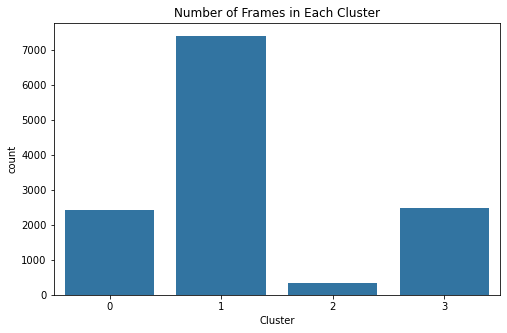

In [93]:
k = 4  # Choose number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clean_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize cluster distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=clean_df)
plt.title("Number of Frames in Each Cluster")
plt.show()

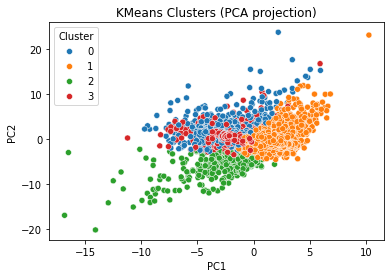

In [94]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clean_df['PC1'] = X_pca[:, 0]
clean_df['PC2'] = X_pca[:, 1]

sns.scatterplot(data=clean_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("KMeans Clusters (PCA projection)")
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Average Silhouette Score: 0.2797


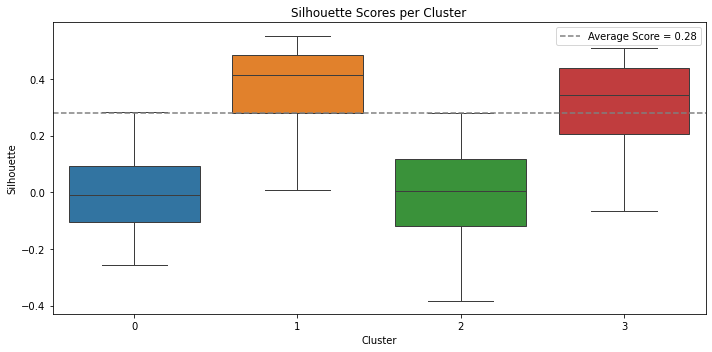

In [102]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clean_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 2: Compute silhouette scores
sil_scores = silhouette_samples(X_scaled, clean_df['Cluster'])
clean_df['Silhouette'] = sil_scores

# Step 3: Overall silhouette score
avg_score = silhouette_score(X_scaled, clean_df['Cluster'])
print(f"Average Silhouette Score: {avg_score:.4f}")

# Step 4: Visualize silhouette scores by cluster
plt.figure(figsize=(10, 5))
sns.boxplot(x='Cluster', y='Silhouette', data=clean_df, palette='tab10')
plt.title("Silhouette Scores per Cluster")
plt.axhline(avg_score, color='gray', linestyle='--', label=f'Average Score = {avg_score:.2f}')
plt.legend()
plt.tight_layout()
plt.show()


Cluster 3 could represent a distinct and consistently repeated pose (e.g., sitting, standing upright)

Cluster 2 might represent noise, transitions, or unusual movements

Cluster 0 and 1 may represent variations of a common motion, such as walking or arm swinging

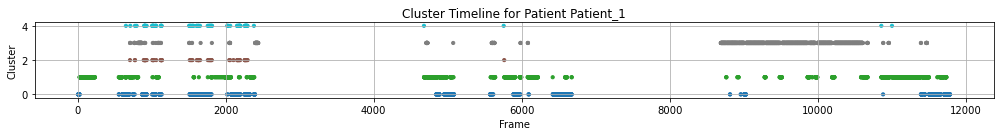

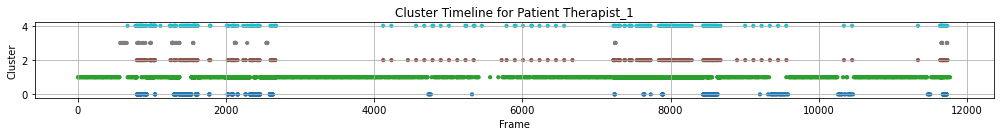

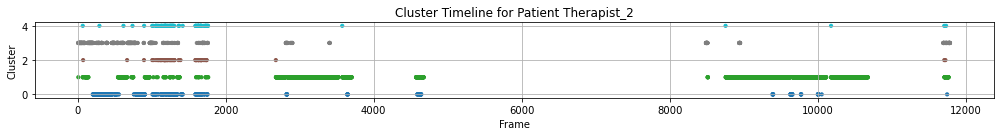

In [111]:
def plot_cluster_timeline(df, patient_id):
    df_patient = df[df['Patient'] == patient_id].sort_values('Frame')
    plt.figure(figsize=(14, 2))
    plt.scatter(df_patient['Frame'], df_patient['Cluster'], c=df_patient['Cluster'], cmap='tab10', s=10)
    plt.title(f"Cluster Timeline for Patient {patient_id}")
    plt.xlabel("Frame")
    plt.ylabel("Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_cluster_timeline(clean_df, 'Patient_1')
plot_cluster_timeline(clean_df, 'Therapist_1')
plot_cluster_timeline(clean_df, 'Therapist_2')

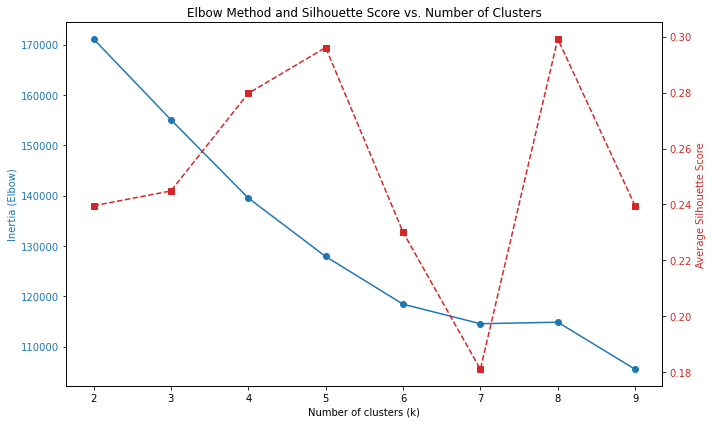

In [103]:
cluster_range = range(2, 10)  # You can extend this to, e.g., 2–15

inertia_scores = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    inertia_scores.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(sil_score)

# Plot Elbow and Silhouette Score together
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color=color)
ax1.plot(cluster_range, inertia_scores, marker='o', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(list(cluster_range))

# Add silhouette on secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Silhouette Score', color=color)
ax2.plot(cluster_range, silhouette_scores, marker='s', linestyle='--', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

# Title
plt.title('Elbow Method and Silhouette Score vs. Number of Clusters')
fig.tight_layout()
plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


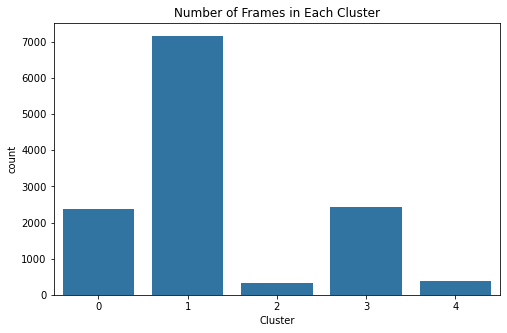

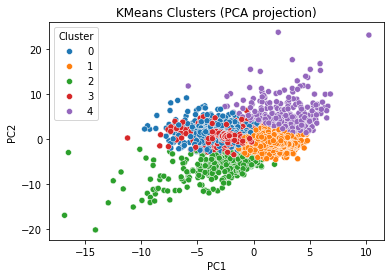

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Average Silhouette Score: 0.2961


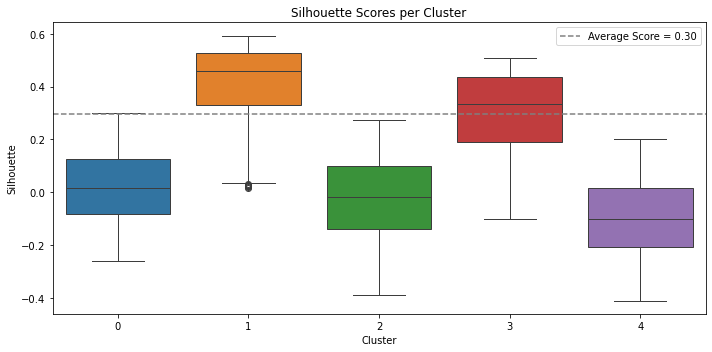

In [110]:
k = 5  # Choose number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clean_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize cluster distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=clean_df)
plt.title("Number of Frames in Each Cluster")
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clean_df['PC1'] = X_pca[:, 0]
clean_df['PC2'] = X_pca[:, 1]

sns.scatterplot(data=clean_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("KMeans Clusters (PCA projection)")
plt.show()

# Step 2: Compute silhouette scores
sil_scores = silhouette_samples(X_scaled, clean_df['Cluster'])
clean_df['Silhouette'] = sil_scores

# Step 3: Overall silhouette score
avg_score = silhouette_score(X_scaled, clean_df['Cluster'])
print(f"Average Silhouette Score: {avg_score:.4f}")

# Step 4: Visualize silhouette scores by cluster
plt.figure(figsize=(10, 5))
sns.boxplot(x='Cluster', y='Silhouette', data=clean_df, palette='tab10')
plt.title("Silhouette Scores per Cluster")
plt.axhline(avg_score, color='gray', linestyle='--', label=f'Average Score = {avg_score:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

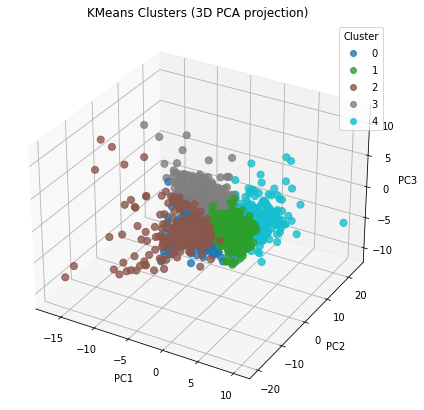

In [112]:
from mpl_toolkits.mplot3d import Axes3D  # Enables 3D plotting

# 3D PCA transformation
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Add the PCA components to the dataframe
clean_df['PC1'] = X_pca[:, 0]
clean_df['PC2'] = X_pca[:, 1]
clean_df['PC3'] = X_pca[:, 2]

# 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Map clusters to colors
scatter = ax.scatter(
    clean_df['PC1'],
    clean_df['PC2'],
    clean_df['PC3'],
    c=clean_df['Cluster'],
    cmap='tab10',
    s=50,
    alpha=0.8
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("KMeans Clusters (3D PCA projection)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


In [124]:
clean_df.to_csv('clustered_data.csv')

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_recall_fscore_support, 
                           roc_auc_score, roc_curve)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
from sklearn.utils.validation import _num_samples


def generate_report(self):
        """Generate comprehensive analysis report"""
        print("\nPOSE CLASSIFICATION ANALYSIS REPORT")
        print("=" * 50)
        
        # Best performing model
        best_model_name = max(self.results.keys(), 
                             key=lambda x: self.results[x]['test_accuracy'])
        best_accuracy = self.results[best_model_name]['test_accuracy']
        
        print(f"Best Performing Model: {best_model_name}")
        print(f"Best Test Accuracy: {best_accuracy:.3f}")
        print(f"Number of Classes: {len(self.class_names)}")
        print(f"Feature Dimensionality: {self.X.shape[1]}")
        print(f"Training Samples: {len(self.X_train)}")
        print(f"Testing Samples: {len(self.X_test)}")
        
        print("\nModel Performance Summary:")
        for name, results in self.results.items():
            cv_mean = np.mean(results['cv_scores'])
            cv_std = np.std(results['cv_scores'])
            print(f"  {name:20s}: {results['test_accuracy']:.3f} "
                  f"(CV: {cv_mean:.3f} ± {cv_std:.3f})")
        



class EnhancedPoseClassifier:
    """
    Enhanced Pose Classification system with advanced preprocessing,
    feature engineering, and model evaluation capabilities.
    """
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.models = {}
        self.results = {}
        self.feature_importance = {}
        
    def load_and_preprocess_data(self, csv_file_path, label_column='label'):
        """
        Load data from CSV file and perform advanced preprocessing with feature engineering
        
        Args:
            csv_file_path: Path to CSV file containing pose data
            label_column: Name of the column containing class labels
        """
        print("Loading and preprocessing data from CSV...")
        
        # Load data from CSV
        df = pd.read_csv(csv_file_path)
        print(f"Loaded CSV with shape: {df.shape}")
        
        # Convert 'Patient' to numeric if needed
        if 'Patient' in df.columns:
            df['Patient'] = df['Patient'].astype('category').cat.codes

        # Ensure label column exists
        if label_column not in df.columns:
            raise ValueError(f"Label column '{label_column}' not found in CSV")

        labels = df[label_column].values

        # Define non-feature columns to exclude from model input
        non_feature_cols = [label_column, 'PC1', 'PC2', 'PC3', 'Silhouette']
        feature_columns = [col for col in df.columns if col not in non_feature_cols]

        # Select only numeric columns for training
        pose_features = df[feature_columns].select_dtypes(include=[np.number]).values

        
        # Reshape pose data if needed (assuming flattened keypoints in CSV)
        n_samples = pose_features.shape[0]
        n_features = pose_features.shape[1]
        
        # If features represent flattened keypoints (x,y coordinates), reshape them
        if n_features % 2 == 0:
            n_keypoints = n_features // 2
            pose_data = pose_features.reshape(n_samples, n_keypoints, 2)
            print(f"Reshaped data to: {n_samples} samples, {n_keypoints} keypoints, 2 coordinates")
        else:
            # If odd number of features, treat as pre-extracted features
            pose_data = pose_features
            print(f"Using pre-extracted features: {n_features} features per sample")
        
        # Convert pose data to advanced feature vectors
        if len(pose_data.shape) == 3:  # If we have keypoint coordinates
            self.X = self._extract_advanced_features(pose_data)
        else:  # If we already have feature vectors
            self.X = pose_data
            
        self.y = self.label_encoder.fit_transform(labels)
        self.class_names = self.label_encoder.classes_
        
        # Data quality checks
        self._data_quality_analysis()
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=self.y
        )
        
        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        print(f"Data preprocessed: {self.X.shape[0]} samples, {self.X.shape[1]} features")
        print(f"Classes: {list(self.class_names)}")
        
    def _extract_advanced_features(self, pose_data):
        """
        Extract comprehensive features from pose keypoints
        
        Features include:
        - Raw coordinates
        - Distances between joints
        - Angles between limbs
        - Spatial relationships
        - Temporal features (if applicable)
        """
        features = []
        
        for pose in pose_data:
            pose_features = []
            
            # Flatten raw coordinates
            pose_features.extend(pose.flatten())
            
            # Calculate distances between key joint pairs
            joint_distances = self._calculate_joint_distances(pose)
            pose_features.extend(joint_distances)
            
            # Calculate limb angles
            limb_angles = self._calculate_limb_angles(pose)
            pose_features.extend(limb_angles)
            
            # Geometric features
            geometric_features = self._calculate_geometric_features(pose)
            pose_features.extend(geometric_features)
            
            features.append(pose_features)
            
        return np.array(features)
    
    def _calculate_joint_distances(self, pose):
        """Calculate distances between important joint pairs"""
        distances = []
        # Define important joint pairs (adjust indices based on your pose format)
        joint_pairs = [
            (0, 1),   # head to neck
            (1, 2),   # neck to shoulder
            (2, 3),   # shoulder to elbow
            (3, 4),   # elbow to wrist
            (1, 5),   # neck to hip
            (5, 6),   # hip to knee
            (6, 7),   # knee to ankle
            (2, 5),   # shoulder to hip
        ]
        
        for i, j in joint_pairs:
            if i < len(pose) and j < len(pose):
                dist = np.linalg.norm(pose[i] - pose[j])
                distances.append(dist)
        
        return distances
    
    def _calculate_limb_angles(self, pose):
        """Calculate angles between limbs"""
        angles = []
        # Define limb triplets for angle calculation
        limb_triplets = [
            (1, 2, 3),  # neck-shoulder-elbow
            (2, 3, 4),  # shoulder-elbow-wrist
            (1, 5, 6),  # neck-hip-knee
            (5, 6, 7),  # hip-knee-ankle
        ]
        
        for i, j, k in limb_triplets:
            if i < len(pose) and j < len(pose) and k < len(pose):
                angle = self._calculate_angle(pose[i], pose[j], pose[k])
                angles.append(angle)
        
        return angles
    
    def _calculate_angle(self, p1, p2, p3):
        """Calculate angle between three points"""
        v1 = p1 - p2
        v2 = p3 - p2
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        cos_angle = np.clip(cos_angle, -1, 1)
        return np.arccos(cos_angle)
    
    def _calculate_geometric_features(self, pose):
        """Calculate geometric properties of the pose"""
        features = []
        
        # Center of mass
        center = np.mean(pose, axis=0)
        features.extend(center)
        
        # Bounding box dimensions
        min_coords = np.min(pose, axis=0)
        max_coords = np.max(pose, axis=0)
        bbox_dims = max_coords - min_coords
        features.extend(bbox_dims)
        
        # Pose compactness (spread of keypoints)
        distances_from_center = [np.linalg.norm(p - center) for p in pose]
        features.extend([np.mean(distances_from_center), np.std(distances_from_center)])
        
        return features
    
    def _data_quality_analysis(self):
        """Analyze data quality and distribution"""
        print("\nData Quality Analysis:")
        print(f"Feature matrix shape: {self.X.shape}")
        print(f"Missing values: {np.isnan(self.X).sum()}")
        print(f"Infinite values: {np.isinf(self.X).sum()}")
        
        # Class distribution
        unique, counts = np.unique(self.y, return_counts=True)
        print("\nClass Distribution:")
        for cls, count in zip(self.class_names[unique], counts):
            print(f"  {cls}: {count} samples ({count/len(self.y)*100:.1f}%)")
    


    def train_models(self):
        print("\nTraining selected models with aggressive regularization...")

        model_configs = {
            'XGBoost': {
                'model': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [3, 4],
                    'learning_rate': [0.01, 0.05],
                    'subsample': [0.6, 0.7],
                    'colsample_bytree': [0.6, 0.7],
                    'reg_alpha': [10, 50, 100],
                    'reg_lambda': [10, 50, 100],
                    'min_child_weight': [1, 5, 10]
                }
            },
            'SVM': {
                'model': SVC(random_state=42, probability=True),
                'params': {
                    'C': [0.01, 0.1, 1],
                    'kernel': ['rbf'],
                    'gamma': ['scale']
                }
            },
            'Neural Network': {
                'model': MLPClassifier(random_state=42, max_iter=1000),
                'params': {
                    'hidden_layer_sizes': [(20,), (30,)],
                    'activation': ['relu'],
                    'alpha': [1, 10, 100],
                    'learning_rate_init': [0.001, 0.01]
                }
            }
        }

        self.models = {}
        self.results = {}

        # Training XGBoost with RandomizedSearchCV (early stopping NOT integrated due to sklearn compatibility)
        print("  Training XGBoost with RandomizedSearchCV...")
        xgb_cfg = model_configs['XGBoost']
        random_search = RandomizedSearchCV(
            estimator=xgb_cfg['model'],
            param_distributions=xgb_cfg['params'],
            n_iter=20,
            scoring='accuracy',
            cv=5,
            verbose=2,
            random_state=42,
            n_jobs=-1
        )
        random_search.fit(self.X_train_scaled, self.y_train)

        best_xgb = random_search.best_estimator_
        train_score = best_xgb.score(self.X_train_scaled, self.y_train)
        test_score = best_xgb.score(self.X_test_scaled, self.y_test)
        cv_scores = cross_val_score(best_xgb, self.X_train_scaled, self.y_train, cv=5)

        self.models['XGBoost'] = best_xgb
        self.results['XGBoost'] = {
            'best_params': random_search.best_params_,
            'train_accuracy': train_score,
            'test_accuracy': test_score,
            'cv_scores': cv_scores
        }
        print(f"    Best params: {random_search.best_params_}")
        print(f"    Train accuracy: {train_score:.3f}")
        print(f"    Test accuracy: {test_score:.3f}")

        # Train other models with GridSearchCV
        for name in ['SVM', 'Neural Network']:
            print(f"  Training {name}...")
            config = model_configs[name]
            grid_search = GridSearchCV(
                config['model'],
                config['params'],
                cv=5,
                scoring='accuracy',
                n_jobs=-1,
                verbose=0
            )
            grid_search.fit(self.X_train_scaled, self.y_train)
            best_model = grid_search.best_estimator_

            train_score = best_model.score(self.X_train_scaled, self.y_train)
            test_score = best_model.score(self.X_test_scaled, self.y_test)
            cv_scores = cross_val_score(best_model, self.X_train_scaled, self.y_train, cv=5)

            self.models[name] = best_model
            self.results[name] = {
                'best_params': grid_search.best_params_,
                'train_accuracy': train_score,
                'test_accuracy': test_score,
                'cv_scores': cv_scores
            }
            print(f"    Best params: {grid_search.best_params_}")
            print(f"    Train accuracy: {train_score:.3f}")
            print(f"    Test accuracy: {test_score:.3f}")

        print("Training complete.")




    
    def evaluate_models(self):
        """Comprehensive model evaluation"""
        print("\nComprehensive Model Evaluation:")
        
        # Create evaluation plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        # 1. Accuracy comparison
        model_names = list(self.results.keys())
        test_accuracies = [self.results[name]['test_accuracy'] for name in model_names]
        
        axes[0].bar(model_names, test_accuracies, color='skyblue')
        axes[0].set_title('Model Accuracy Comparison')
        axes[0].set_ylabel('Test Accuracy')
        axes[0].tick_params(axis='x', rotation=45)
        
        # 2. Cross-validation scores
        cv_data = [self.results[name]['cv_scores'] for name in model_names]
        axes[1].boxplot(cv_data, labels=model_names)
        axes[1].set_title('Cross-Validation Score Distribution')
        axes[1].set_ylabel('CV Accuracy')
        axes[1].tick_params(axis='x', rotation=45)
        
        # 3. Feature importance (for tree-based models)
        best_model_name = max(model_names, key=lambda x: self.results[x]['test_accuracy'])
        best_model = self.models[best_model_name]
        
        if hasattr(best_model, 'feature_importances_'):
            feature_imp = best_model.feature_importances_
            top_features = np.argsort(feature_imp)[-10:]
            axes[2].barh(range(10), feature_imp[top_features])
            axes[2].set_title(f'Top 10 Features - {best_model_name}')
            axes[2].set_xlabel('Feature Importance')
        
        # 4. Confusion matrix for best model
        y_pred = best_model.predict(self.X_test_scaled)
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.class_names, yticklabels=self.class_names, ax=axes[3])
        axes[3].set_title(f'Confusion Matrix - {best_model_name}')
        
        # 5. ROC curves (for binary classification or OvA)
        if len(self.class_names) == 2:
            y_proba = best_model.predict_proba(self.X_test_scaled)[:, 1]
            fpr, tpr, _ = roc_curve(self.y_test, y_proba)
            auc = roc_auc_score(self.y_test, y_proba)
            axes[4].plot(fpr, tpr, label=f'AUC = {auc:.3f}')
            axes[4].plot([0, 1], [0, 1], 'k--')
            axes[4].set_title('ROC Curve')
            axes[4].set_xlabel('False Positive Rate')
            axes[4].set_ylabel('True Positive Rate')
            axes[4].legend()
        
        # 6. Training vs Test accuracy
        train_acc = [self.results[name]['train_accuracy'] for name in model_names]
        test_acc = [self.results[name]['test_accuracy'] for name in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        axes[5].bar(x - width/2, train_acc, width, label='Train', alpha=0.8)
        axes[5].bar(x + width/2, test_acc, width, label='Test', alpha=0.8)
        axes[5].set_title('Train vs Test Accuracy')
        axes[5].set_ylabel('Accuracy')
        axes[5].set_xticks(x)
        axes[5].set_xticklabels(model_names, rotation=45)
        axes[5].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed classification report for best model
        print(f"\nDetailed Classification Report for {best_model_name}:")
        print(classification_report(self.y_test, y_pred, target_names=[str(cls) for cls in self.class_names]))

        
        return best_model_name, best_model
    
    def feature_analysis(self):
        """Advanced feature analysis and dimensionality reduction"""
        print("\nFeature Analysis:")
        
        # PCA Analysis
        pca = PCA()
        X_pca = pca.fit_transform(self.X_train_scaled)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # 1. PCA explained variance
        cumsum_var = np.cumsum(pca.explained_variance_ratio_)
        axes[0].plot(cumsum_var)
        axes[0].set_title('PCA Explained Variance')
        axes[0].set_xlabel('Number of Components')
        axes[0].set_ylabel('Cumulative Explained Variance')
        axes[0].grid(True)
        
        # Find number of components for 95% variance
        n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
        axes[0].axvline(x=n_components_95, color='red', linestyle='--', 
                       label=f'95% variance: {n_components_95} components')
        axes[0].legend()
        
        # 2. PCA 2D visualization
        pca_2d = PCA(n_components=2)
        X_pca_2d = pca_2d.fit_transform(self.X_train_scaled)
        
        for i, class_name in enumerate(self.class_names):
            mask = self.y_train == i
            axes[1].scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                           label=class_name, alpha=0.7)
        axes[1].set_title('PCA 2D Projection')
        axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2f})')
        axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2f})')
        axes[1].legend()
        
        # 3. t-SNE visualization
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_tsne = tsne.fit_transform(self.X_train_scaled)
        
        for i, class_name in enumerate(self.class_names):
            mask = self.y_train == i
            axes[2].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                           label=class_name, alpha=0.7)
        axes[2].set_title('t-SNE 2D Projection')
        axes[2].set_xlabel('t-SNE 1')
        axes[2].set_ylabel('t-SNE 2')
        axes[2].legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"PCA Analysis:")
        print(f"  Components for 95% variance: {n_components_95}")
        print(f"  Total features: {self.X.shape[1]}")
        print(f"  Dimensionality reduction potential: {(1 - n_components_95/self.X.shape[1])*100:.1f}%")
    
    def generate_report(self):
        """Generate comprehensive analysis report"""
        print("\n📋 POSE CLASSIFICATION ANALYSIS REPORT")
        print("=" * 50)
        
        # Best performing model
        best_model_name = max(self.results.keys(), 
                             key=lambda x: self.results[x]['test_accuracy'])
        best_accuracy = self.results[best_model_name]['test_accuracy']
        
        print(f" Best Performing Model: {best_model_name}")
        print(f" Best Test Accuracy: {best_accuracy:.3f}")
        print(f" Number of Classes: {len(self.class_names)}")
        print(f" Feature Dimensionality: {self.X.shape[1]}")
        print(f" Training Samples: {len(self.X_train)}")
        print(f" Testing Samples: {len(self.X_test)}")
        
        print("\n Model Performance Summary:")
        for name, results in self.results.items():
            cv_mean = np.mean(results['cv_scores'])
            cv_std = np.std(results['cv_scores'])
            print(f"  {name:20s}: {results['test_accuracy']:.3f} "
                  f"(CV: {cv_mean:.3f} ± {cv_std:.3f})")
        



# print("1. Feature Engineering: Consider adding temporal features if sequential data available")
# print("2. Data Augmentation: Apply geometric transformations to increase dataset size")
# print("3. Ensemble Methods: Combine top performing models for better accuracy")
# print("4. Hyperparameter Tuning: Fine-tune the best model further")
# print("5. Cross-validation: Use stratified k-fold for better evaluation")


Loading and preprocessing data from CSV...
Loaded CSV with shape: (12648, 24)
Using pre-extracted features: 19 features per sample

Data Quality Analysis:
Feature matrix shape: (12648, 19)
Missing values: 0
Infinite values: 0

Class Distribution:
  0: 2361 samples (18.7%)
  1: 7161 samples (56.6%)
  2: 330 samples (2.6%)
  3: 2423 samples (19.2%)
  4: 373 samples (2.9%)
Data preprocessed: 12648 samples, 19 features
Classes: [0, 1, 2, 3, 4]

Training selected models with aggressive regularization...
  Training XGBoost with RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
    Best params: {'subsample': 0.7, 'reg_lambda': 50, 'reg_alpha': 10, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
    Train accuracy: 0.978
    Test accuracy: 0.965
  Training SVM...
    Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
    Train accuracy: 0.994
    Test accuracy: 0.976
  Training Neural Network...

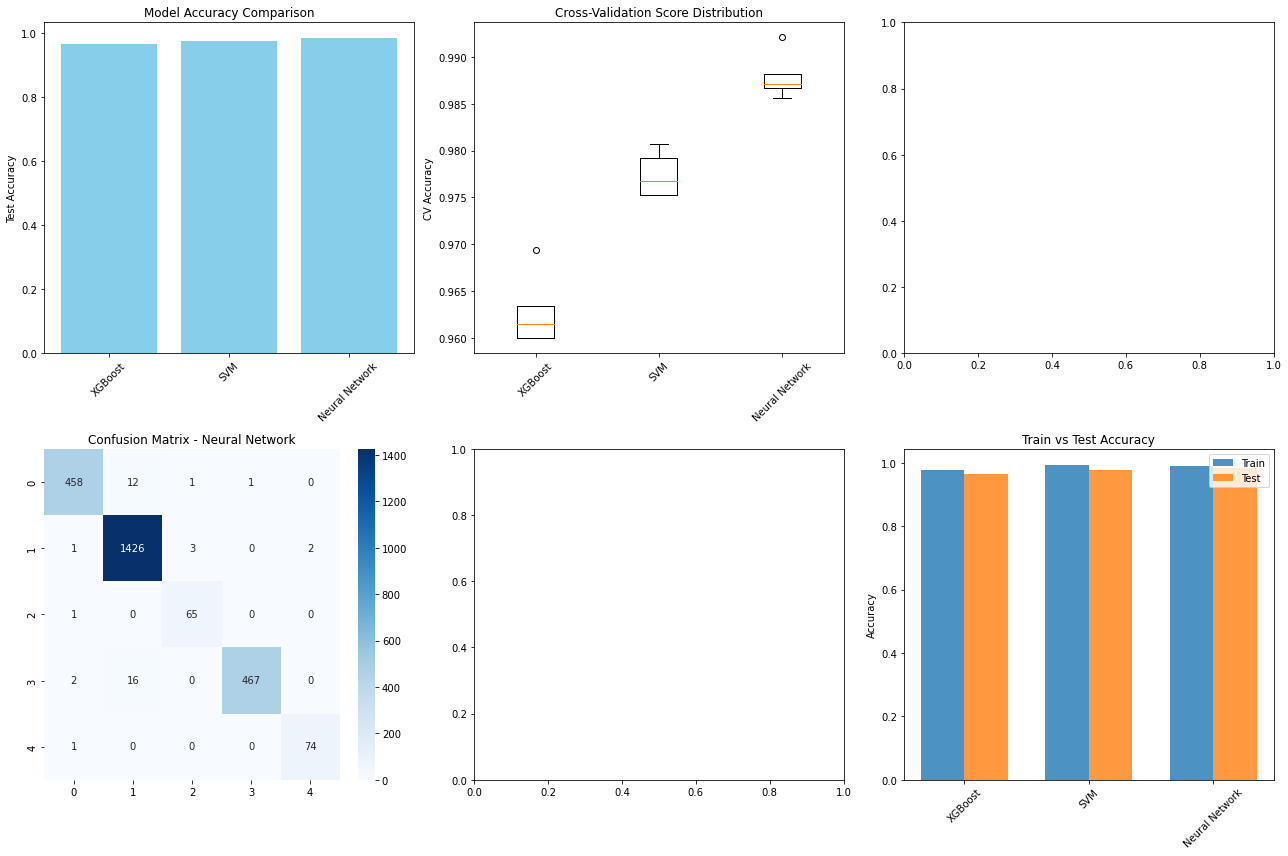


Detailed Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       472
           1       0.98      1.00      0.99      1432
           2       0.94      0.98      0.96        66
           3       1.00      0.96      0.98       485
           4       0.97      0.99      0.98        75

    accuracy                           0.98      2530
   macro avg       0.98      0.98      0.98      2530
weighted avg       0.98      0.98      0.98      2530


Feature Analysis:


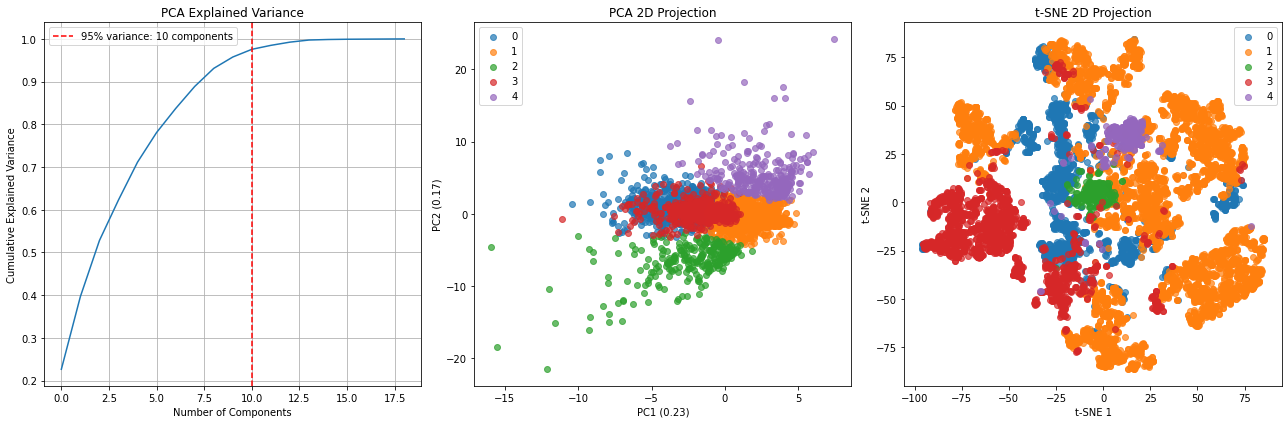

PCA Analysis:
  Components for 95% variance: 10
  Total features: 19
  Dimensionality reduction potential: 47.4%

📋 POSE CLASSIFICATION ANALYSIS REPORT
 Best Performing Model: Neural Network
 Best Test Accuracy: 0.984
 Number of Classes: 5
 Feature Dimensionality: 19
 Training Samples: 10118
 Testing Samples: 2530

 Model Performance Summary:
  XGBoost             : 0.965 (CV: 0.963 ± 0.004)
  SVM                 : 0.976 (CV: 0.977 ± 0.002)
  Neural Network      : 0.984 (CV: 0.988 ± 0.002)


In [155]:
if __name__ == "__main__":
    classifier = EnhancedPoseClassifier()
    classifier.load_and_preprocess_data(csv_file_path='clustered_data.csv', label_column='Cluster')
    classifier.train_models()
    best_model_name, best_model = classifier.evaluate_models()
    classifier.feature_analysis()
    classifier.generate_report()